In [1]:
from pylab import *
%matplotlib inline

In [2]:
caffe_root = '/Users/mohamed/Code/lib/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

In [3]:
# create our model deeexpression
from caffe import layers as L, params as P

def deXpression(lmdb, mean_file, batch_size, mirror=False):
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                            transform_param=dict(mirror=mirror, crop_size= 224, mean_file=mean_file), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=7, num_output=64, stride=2, pad=3, weight_filler=dict(type="msra", variance_norm=0),
                            bias_filler=dict(type="constant"))
    n.conv1_relu1 = L.ReLU(n.conv1, in_place=True)
    n.pool1 = L.Pooling(n.conv1, kernel_size=3, stride=2, pad=0, pool=P.Pooling.MAX)
    n.pool1_norm1 = L.LRN(n.pool1, local_size= 5, alpha= 0.0001, beta= 0.75)
    n.conv2a = L.Convolution(n.pool1_norm1, kernel_size=1, num_output=96, stride=1, pad=0, weight_filler=dict(type="msra", variance_norm=0),
                            bias_filler=dict(type="constant"))
    n.conv2a_relu2a = L.ReLU(n.conv2a, in_place=True)
    n.pool2a = L.Pooling(n.pool1_norm1, kernel_size=3, stride=1, pad=1, pool=P.Pooling.MAX)
    n.conv2b = L.Convolution(n.conv2a, kernel_size=3, num_output=208, stride=1, pad=1, weight_filler=dict(type="msra", variance_norm=0),
                            bias_filler=dict(type="constant"))
    n.conv2b_relu2b = L.ReLU(n.conv2b, in_place=True)
    n.conv2c = L.Convolution(n.pool2a, kernel_size=1, num_output=64, stride=1, pad=0, weight_filler=dict(type="msra", variance_norm=0),
                            bias_filler=dict(type="constant"))
    n.conv2c_relu2c = L.ReLU(n.conv2c, in_place=True)
    n.concat2 = L.Concat(n.conv2b, n.conv2c)
    n.pool2b = L.Pooling(n.concat2, kernel_size=3, stride=2, pad=0, pool=P.Pooling.MAX)
    n.conv3a = L.Convolution(n.pool2b, kernel_size=1, num_output=96, stride=1, pad=0, weight_filler=dict(type="msra", variance_norm=0),
                            bias_filler=dict(type="constant"))
    n.conv3a_relu3a = L.ReLU(n.conv3a, in_place=True)
    n.pool3a = L.Pooling(n.pool2b, kernel_size=3, stride=1, pad=1, pool=P.Pooling.MAX)
    n.conv3b = L.Convolution(n.conv3a, kernel_size=3, num_output=208, stride=1, pad=1, weight_filler=dict(type="msra", variance_norm=0),
                            bias_filler=dict(type="constant"))
    n.conv3b_relu3b = L.ReLU(n.conv3b, in_place=True)
    n.conv3c = L.Convolution(n.pool3a, kernel_size=1, num_output=64, stride=1, pad=0, weight_filler=dict(type="msra", variance_norm=0),
                            bias_filler=dict(type="constant"))
    n.conv3c_relu3c = L.ReLU(n.conv3c, in_place=True)
    n.concat3 = L.Concat(n.conv3b, n.conv3c)
    n.pool3b = L.Pooling(n.concat3, kernel_size=3, stride=2, pad=0, pool=P.Pooling.MAX)
    n.score = L.InnerProduct(n.pool3b, num_output=11, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

# train
with open('deXpression_train.prototxt', 'wb') as f:
    f.write(str(deXpression('/Users/mohamed/Code/lib/DIGITS/digits/jobs/20160320-202534-d7ae/train_db',
                            '/Users/mohamed/Code/lib/DIGITS/digits/jobs/20160320-202534-d7ae/mean.binaryproto', 75, mirror=True)))
# val test   
with open('deXpression_val.prototxt', 'wb') as f:
    f.write(str(deXpression('/Users/mohamed/Code/lib/DIGITS/digits/jobs/20160320-202534-d7ae/val_db',
                            '/Users/mohamed/Code/lib/DIGITS/digits/jobs/20160320-202534-d7ae/mean.binaryproto', 75)))

Iteration 0 testing...
Iteration 60 testing...
Iteration 120 testing...
Iteration 180 testing...
Iteration 240 testing...
Iteration 300 testing...
Iteration 360 testing...
Iteration 420 testing...
Iteration 480 testing...
Iteration 540 testing...


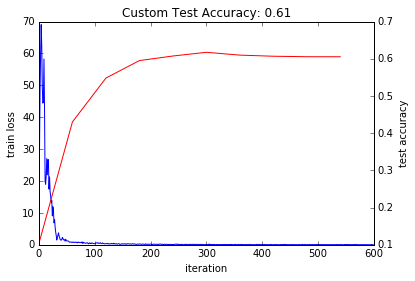

In [3]:
train_net_path = './deXpression_train.prototxt'
test_net_path = './deXpression_val.prototxt'
solver_config_path = './solver.prototxt'


### define solver
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# Set a seed for reproducible experiments:
# this controls for randomization in training.
s.random_seed = 0xCAFFE

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 10  # Test after every 500 training iterations.
s.test_iter.append(15) # Test on 100 batches each time we test.

s.max_iter = 600     # no. of times to update the net (training iterations)
 
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "Adam"

# Set the initial learning rate for SGD.
s.base_lr = 0.0001  # EDIT HERE to try different learning rates
# Set momentum to accelerate learning by
# taking weighted average of current and previous updates.
s.momentum = 0.9
s.momentum2= 0.999
# Set weight decay to regularize and prevent overfitting
s.weight_decay = 0.0001
s.delta= 0.00000001
    
# Set `lr_policy` to define how the learning rate changes during training.
# This is the same policy as our default LeNet.
s.lr_policy = 'step'
s.stepsize = 430
s.gamma = 0.0001
#s.power = 0.75
# EDIT HERE to try the fixed rate (and compare with adaptive solvers)
# `fixed` is the simplest policy that keeps the learning rate constant.
# s.lr_policy = 'fixed'

# Display the current training loss and accuracy every 1000 iterations.
s.display = 10

# Snapshots are files used to store networks we've trained.
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 500
s.snapshot_prefix = 'deXpression/custom_net'

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.CPU

# Write the solver to a temporary file and return its filename.
with open(solver_config_path, 'w') as f:
    f.write(str(s))

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.get_solver(solver_config_path)

### solve
niter = 600  # EDIT HERE increase to train for longer
test_interval = niter / 10
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['classifier'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))